## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## Define a function to extract HOG features

In [1]:
import cv2
import pickle
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# visualization will be shown in the notebook
%matplotlib inline

from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

def plot_image_comparison(image1, image2, title1='Image 1', title2='Image 2', cmap1='', cmap2=''):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    if cmap1 == '':
        ax1.imshow(image1)
    else:
        ax1.imshow(image1, cmap=cmap1)
    if cmap2 == '':
        ax2.imshow(image2)
    else:
        ax2.imshow(image2, cmap=cmap2)
    ax1.set_title(title1, fontsize=20)
    ax2.set_title(title2, fontsize=20)

def get_random_image_paths(img_type='car', size=2, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
        
    if img_type == 'car':
        cars = np.array([path for path in glob.iglob('data/vehicles/*/*.png', recursive=True)])
        if size > 0:
            nums = np.random.randint(0, len(cars), size=size)
            return cars[nums]
        else:
            return cars
    elif img_type == 'not-car':
        notcars = np.array([path for path in glob.iglob('data/non-vehicles/*/*.png', recursive=True)])
        if size > 0:
            nums = np.random.randint(0, len(notcars), size=size)
            return notcars[nums]
        else:
            return notcars

def get_random_images(img_type='car', size=2, random_seed=None):
    return [mpimg.imread(img_path) for img_path in get_random_image_paths(img_type, size, random_seed)]
        

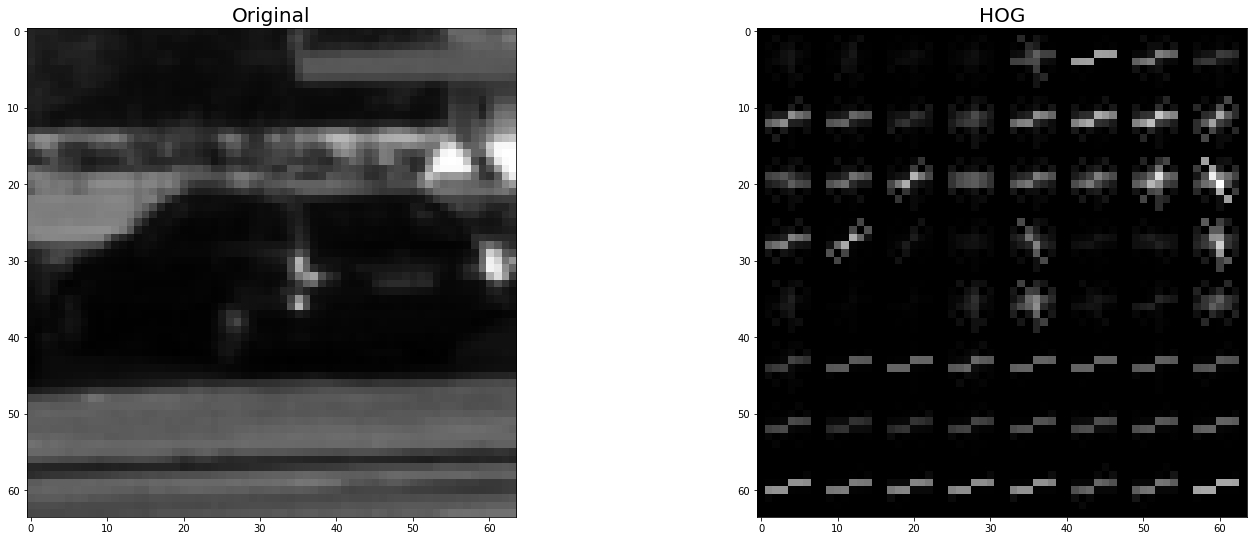

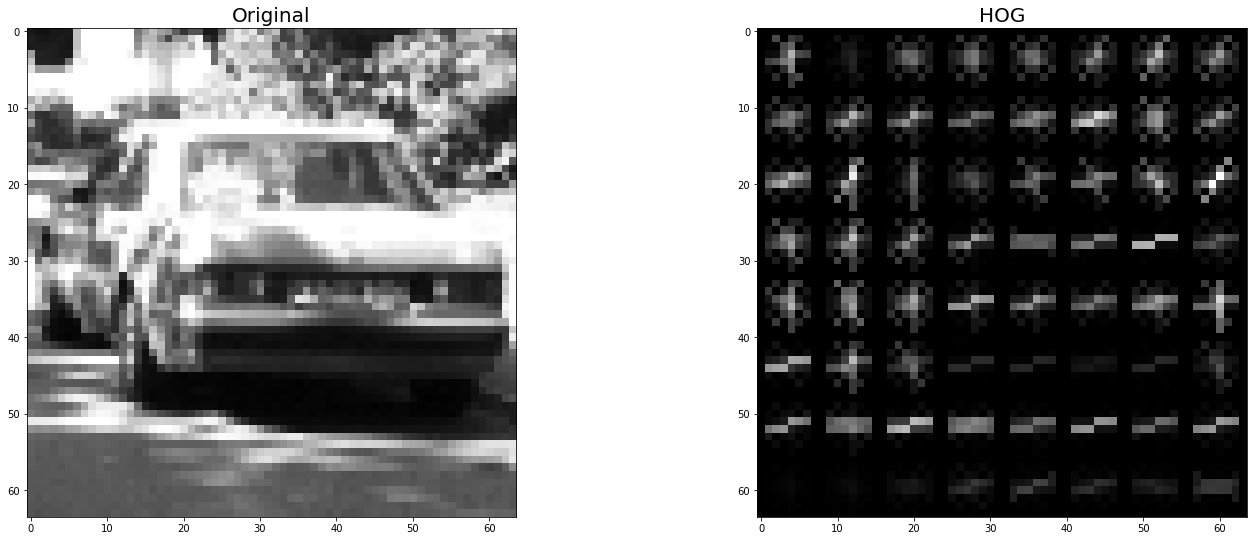

In [2]:
# show examples of the undistorted image
import numpy as np

img_paths = get_random_image_paths('car')

orientation = 9
pix_per_cell = 8
cell_per_block = 8

for img_path in img_paths:
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray, orientation, pix_per_cell, cell_per_block, vis=True)
    plot_image_comparison(gray, hog_image, 'Original', 'HOG', 'gray', 'gray')


## Define functions to extract color features from the images

In [3]:
import numpy as np


def bin_spatial(img, size=(32, 32)):
    # this is downsampling of the image
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



## Define functions to extract features

In [4]:
def get_single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


def get_multiple_img_features(imgs, color_space='RGB', spatial_size=(32, 32),
                              hist_bins=32, orient=9, 
                              pix_per_cell=8, cell_per_block=2, hog_channel=0,
                              spatial_feat=True, hist_feat=True, hog_feat=True):
    all_features = []
    for img in imgs:
        all_features.append(get_single_img_features(img, color_space, spatial_size, hist_bins, orient,
                                                    pix_per_cell, cell_per_block, hog_channel,
                                                    spatial_feat, hist_feat, hog_feat))
    return all_features

## Define a SVC training pipeline

In [5]:
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

def train_svc(n_samples=-1, color_space='RGB', orient=9, pix_per_cell=8, spatial_size=32, hist_bins=32, random_seed=None):
    # below are the hyper params can be tuned
    #     color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    #     orient = 9  # HOG orientations
    #     pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (spatial_size, spatial_size) # Spatial binning dimensions
    hist_bins = hist_bins    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    print('Using:',orient,'orientations,',pix_per_cell, 'pixels per cell,',
          cell_per_block,'cells per block,', spatial_size, 'spatial size and"', color_space, '" color space.')

    print("Getting {} images...".format(n_samples if n_samples > 0 else 'all'))
    test_cars = get_random_images('car', n_samples, random_seed)
    test_notcars = get_random_images('not-car', n_samples, random_seed)

    t = time.time()
    print("Extracting features from these images...")
    car_features = get_multiple_img_features(test_cars, color_space=color_space, 
                                             spatial_size=spatial_size, hist_bins=hist_bins, 
                                             orient=orient, pix_per_cell=pix_per_cell, 
                                             cell_per_block=cell_per_block, 
                                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                             hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = get_multiple_img_features(test_notcars, color_space=color_space, 
                                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                                orient=orient, pix_per_cell=pix_per_cell, 
                                                cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                hist_feat=hist_feat, hog_feat=hog_feat)

    print("It took {:.4f} seconds to compute features".format(time.time()-t))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = random_seed or np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('It took {:.4f} seconds to train SVC...'.format(t2-t))
    # Check the score of the SVC
    test_accuracy = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', test_accuracy)
    # Check the prediction time for a single sample
    t3=time.time()
    print('It took {:.4f} seconds to predict  SVC...'.format(t3-t2))
    
    stats = {'test_accuracy': test_accuracy, 'train_time': t2 - t, 'feature_size': len(X_train[0])}

    return svc, X_scaler, stats

## Fine-tuning the hyper-parameters for SVC
For good detection, hyper-parameter tuning is important. The fine-tuning used the values provided in the course as a starting point, which established a about 0.94 baseline, then I tried different orient, pix_per_cell, but doesn't seem too much improvement. Then I tried the `hog_channel` to set to 'All', which helped improvement. Then I tried different color space, which have a lot variations in performance from 0.91 to 0.99. 
I finally did a grid search on some of the promising `color_spaces`, `orients` and `pix_per_cells`, I compared on test accuracy and the number of features. I want high accuracy and low number of features. Which I finally settle on: `6 orientations, 8 pixels per cell, 2 cells per block, and" YUV " color space.`


In [6]:
import pickle

def parameter_search():
    color_spaces = ['RGB', 'YCrCb', 'YUV', 'HSV']
    orients = [6, 9, 12]
    pix_per_cells = [6, 8, 10]
    spatial_sizes = [16, 32]
    hist_bins = 32
    n_samples = 1000 # if -1, train with all data, else it is on some data

    svc_idx = 0
    trained_svcs = {}
    random_seed = np.random.randint(0, 100)
    for color_space in color_spaces:
        for orient in orients:
            for pix_per_cell in pix_per_cells:
                for spatial_size in spatial_sizes:
                    print("="*30)
                    ## train on all data
                    svc, X_scaler, stats = train_svc(n_samples, color_space, orient, pix_per_cell, spatial_size, hist_bins, random_seed)

                    svc_idx += 1
                    save_obj = {"color_space": color_space, "orient": orient, "pix_per_cell": pix_per_cell, "cell_per_block": cell_per_block,
                    "svc": svc, "scaler": X_scaler, "spatial_size": spatial_size, "hist_bins": hist_bins, "stats": stats}

                    # save a model once trained using the following convensions for file names
                    save_path = "models/trained_svc_{}_{}_{}_{}.p".format(color_space, orient, pix_per_cell, spatial_size)
                    pickle.dump(save_obj, open(save_path, 'wb'))
    
    # TODO: can do more quantitative analysis than just eye-balling

# uncomment below line to do the search
# parameter_search()

## Train the classifier on all data

In [7]:
def train_on_all_data():
    color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 6  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    svc, X_scaler = train_svc( color_space=color_space, orient=orient, pix_per_cell=pix_per_cell)

    # Save the trained object for later extraction
    save_obj = {"color_space": color_space, "orient": orient, "pix_per_cell": pix_per_cell, "cell_per_block": cell_per_block,
                "svc": svc, "scaler": X_scaler, "spatial_size": spatial_size, "hist_bins": hist_bins}

    pickle.dump(save_obj, open('trained_svc.p', 'wb'))

    print("Trained SVC classifier saved at 'trained_svc.p'.")

# uncomment the following line if desired to train the SVC on all data
# train_on_all_data()

## Define a sliding window algorithm
This algorithm will return a list of window bounding boxes based on the size and overlapping criteria the caller defines. 

In [8]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=5):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using get_single_img_features()
        features = get_single_img_features(test_img, color_space=color_space, 
                                           spatial_size=spatial_size, hist_bins=hist_bins, 
                                           orient=orient, pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, 
                                           hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                           hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


## Test on a single image

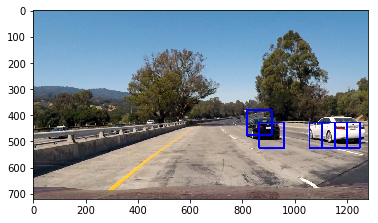

In [10]:
dist_pickle = pickle.load(open("trained_svc.p", "rb" ))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]
hog_channel = 'ALL'

img = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(img)
y_start_stop = [380, 700]


# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
img = img.astype(np.float32)/255

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

## Improve on the search window algorithm

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
# it returns a list of bounding boxes of where the prediction thinks the cars are
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # assuming the img loaded is of jpg format from "mpimg.imread()" function
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2{}'.format(color_space))
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))     
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list

# a convenience function to do multi-scale search on a given image based on a saved model
def find_cars_multi_scale(img, saved_model="trained_svc.p", scales=[1.0, 1.5]):
    dist_pickle = pickle.load(open(saved_model, "rb" ))
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    color_space = dist_pickle["color_space"]
    
    # these are hyper parameters to define areas to search the cars from an image, just hard-coded for now
    ystart = 400
    ystop = 656
    bboxes = []
    for scale in scales:
        bboxes.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    return bboxes

# find all bounding boxes of cars for a number of images based on several scales
# returns a map with key="image path", value="found bboxes for the image"
def find_cars_batch(img_paths, saved_model="trained_svc.p", scales=[1.0, 1.5]):
    result = {}     # a map with key=img_path, value=found_bboxes
    for img_path in img_paths:
        img = mpimg.imread(img_path)
        result[img_path] = find_cars_multi_scale(img, saved_model, scales)

    return result

## Test on multiple images for finding car

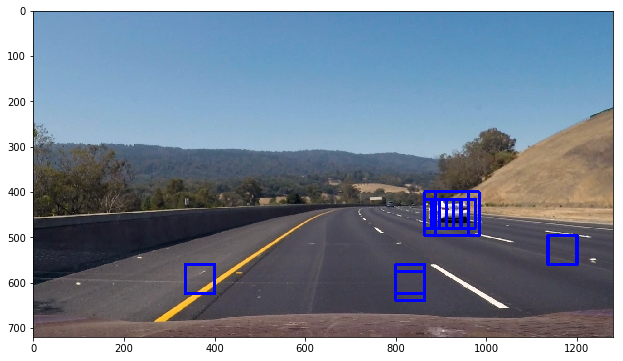

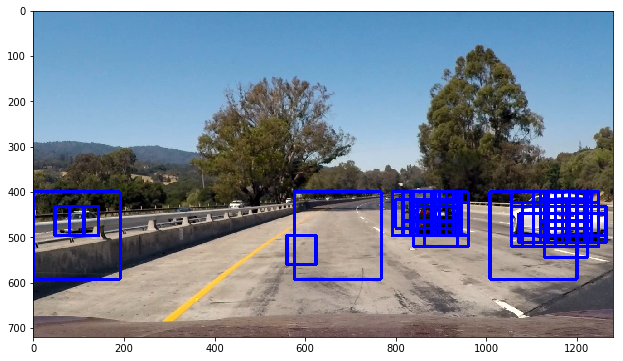

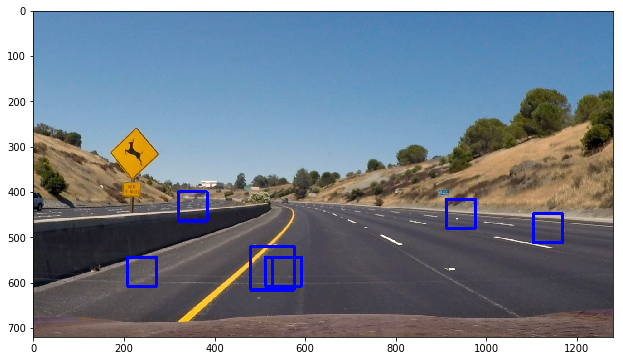

In [28]:
bbox_list = find_cars_batch(glob.glob('test_images/*.jpg')[0:3], scales=[1.0, 1.5, 3.0])

for img_path, bboxes in bbox_list.items():
    img = mpimg.imread(img_path)
    out_img = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
    plt.figure(figsize=(16, 6))
    plt.imshow(out_img)

## Define functions to remove redendunt boxes and false positives
Specifically, need to make a few functions to fuse the detection boxes together and remove false positives

In [13]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## Test on a few example images

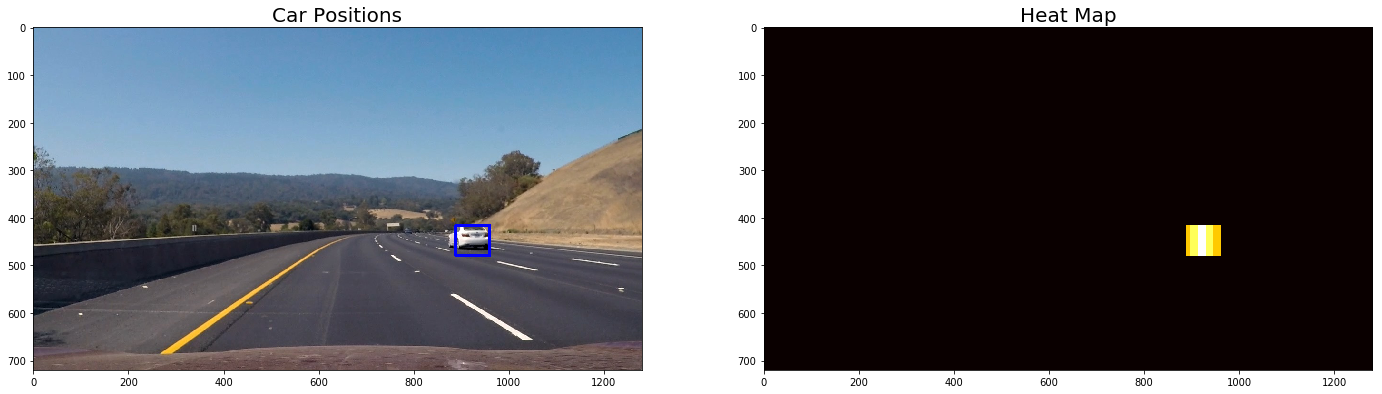

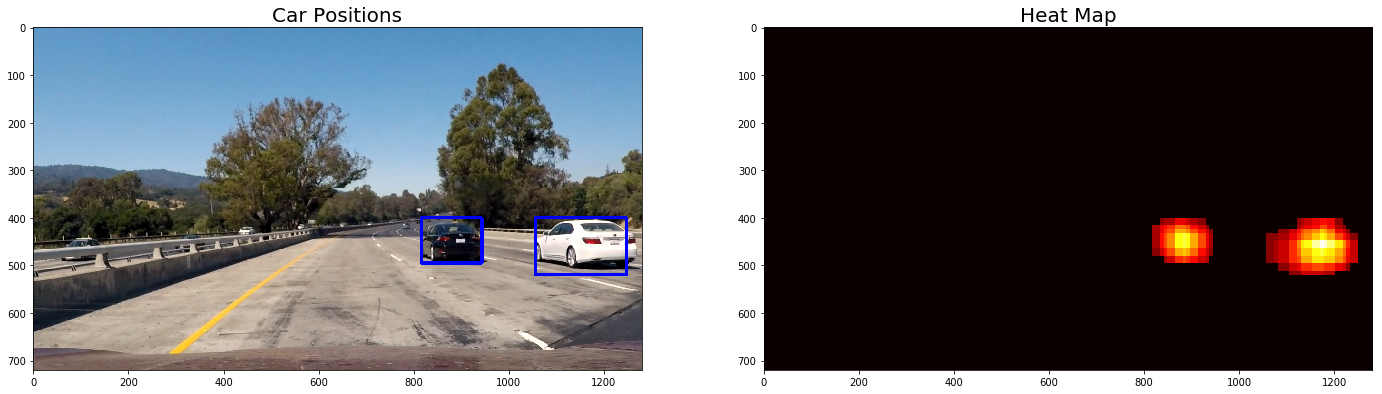

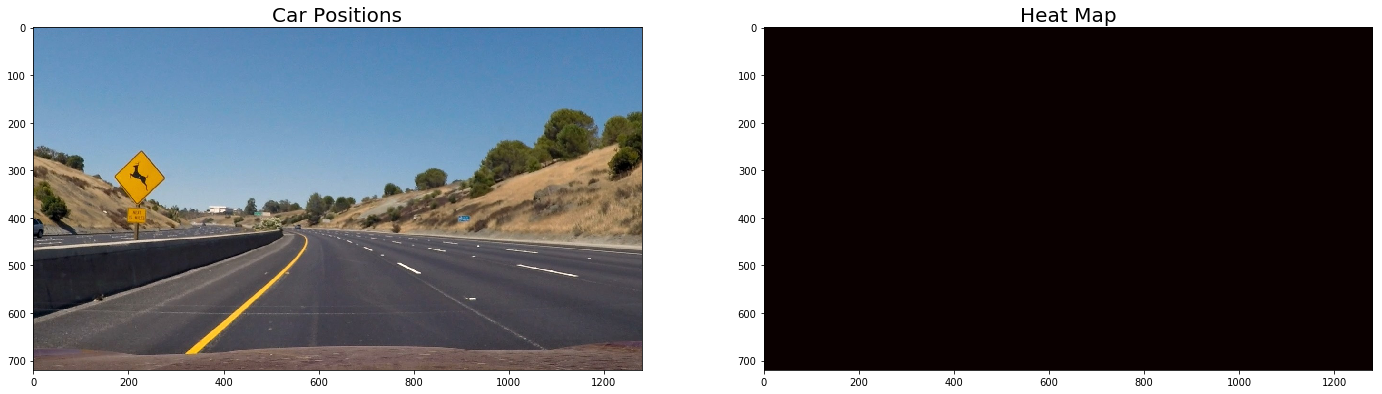

In [29]:
# uncomment this line below if the bbox_list is not available yet
# bbox_list = find_cars_batch(glob.glob('test_images/*.jpg')[0:3])

for img_path, bboxes in bbox_list.items():
    img = mpimg.imread(img_path)
    out_img = draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)

    # Create heat map and add each box in the box list of this image
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    # Plot the final boxes on the image and the heat map for comparison
    plot_image_comparison(draw_img, heatmap, 'Car Positions', 'Heat Map', '', 'hot')


## Define a pipeline for Vehicle Detection

In [30]:
def process_image(img):
    bbox_list = find_cars_multi_scale(img)

    # Create heat map and add each box in the box list of this image
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    return draw_labeled_bboxes(np.copy(img), labels)

## Test on the video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

# Now, run the video and the pipeline on the video
input_video_path = "project_video.mp4"
output_video_path = "output_videos/project_video.mp4"

clip1 = VideoFileClip(input_video_path)
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video_path, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 55%|██████████████████████████████████████████████████████████████████████████████████                                                                   | 695/1261 [19:23<17:42,  1.88s/it]

In [ ]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_path))